# Linear Downscaling for Temperature (Monthly)

#### Katrina Wheelan, 4.3.20

This notebook uses various atmospheric predictors to predict maximum temperature. There is an option to add a stochastic component to the linear model.

Steps: 

- Import data
- standardize
- LASSO or manual selection linear regression using large scale predictors
- condition on month of the year
- stochastic piece --- Gaussian or Gamma distribution
- save predictions

### Importing the necessary packages

In [35]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import sklearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import os

## Input Coordinates

In [36]:
#Adjust these if needed; takes a single cell
lat = 38.125
lon = -101.875

## Prepping the Data for analysis

Run the code below or skip to the cell with the stars if you want to use pre-prepped data for (36.608, -97.488)

### Importing the predictors

In [37]:
ROOT = '/glade/p/cisl/risc/rmccrary/DOE_ESD/LargeScale_DCA/ERA-I/mpigrid/' #where the files are saved
EXT = '_19790101-20181231_dayavg_mpigrid.nc' #date range at the end of the file
SERIES = 'ERAI_NAmerica'

#The variables to use
surface_predictors = ['mslp', 'uas', 'vas'] #, 'ps']
#Each of these predictors is taken at each pressure level below
other_predictors = ['Q', 'RH', 'U', 'V', 'Z', 'Vort', 'Div']
levels = [500, 700, 850] #pressure levels

#Surface predictors
for var in surface_predictors:
    file = ROOT + var + '_' + SERIES + '_surf' + EXT
    if var == 'mslp': predictors = xr.open_dataset(file)[var]
    predictors = xr.merge([predictors, xr.open_dataset(file)[var]])

#Other predictors (at multiple pressure levels)
for var in other_predictors:
    for level in levels:
        file = ROOT + var + '_' + SERIES + '_p' + str(level) + EXT
        predictors = xr.merge([predictors, xr.open_dataset(file).rename({var: var + '_p' + str(level)})])

### Standardizing the input variables

In [38]:
#convert to pandas dataframe in order to use scikit-learn later

def standardize(variable):
    """Standardizing a variable (converting to z-scores)
    Takes as input an Xarray dataset; outputs a standardized Xarray object"""
    return (variable - np.mean(variable)) / np.std(variable)

for col in [i for i in predictors.keys()]:
    #standardize each predictor
    predictors[col] = standardize(predictors[col])

### Get observations and training data

In [106]:
#import observations
obs_file = "/glade/p/cisl/risc/narccap/obs/gridMET/common/DCA/tmax.gridMET.NAM-22i.SGP.nc"
obs = xr.open_mfdataset(obs_file).sel(time = slice('1979-01-01','2014-12-31'))

#getting training data 
#slicing input data to the date range of obs (through 2014)
X_all = predictors.sel(lat = lat, lon = lon, method = 'nearest').sel(time = slice('1980-01-01','2014-12-31'))
Y_all = obs.sel(lat = lat, lon = lon, method = 'nearest').sel(time = slice('1980-01-01','2014-12-31'))

### Conditioning by month

In [107]:
for dataset in [X_all, Y_all]:
    #adding a variable for month into the input and obs datasets
    all_preds = [key for key in dataset.keys()] #the names of the predictors
    dataset['month'] = dataset.time.dt.month
    if not 'month' in all_preds: all_preds += ['month'] #adding "month" to the list of variable names

### Selecting a Month

Set the variable month equal to the number of the desired month (ie. January = 1)

In [108]:
#chosen month
month = 1

#subseting the data
#fix this code
X_all['timecopy'] = X_all['time']
X_all['time'] = X_all['month']
X_month = X_all.sel(time = month)
X_month['time'] = X_month['timecopy']
X_month = X_month.drop(['timecopy', 'month'])

Y_all['timecopy'] = Y_all['time']
Y_all['time'] = Y_all['month']
Y_month = Y_all.sel(time = month)
Y_month['time'] = Y_month['timecopy']
Y_month = Y_month.drop(['timecopy', 'month'])

### Add a column of ones for constants

In [109]:
#adding a column of ones for a constant (since the obs aren't normalized they aren't centered around zero)
all_preds = [key for key in X_month.keys()] #the names of the predictors
X_month['constant'] = 1 + 0*X_month[all_preds[0]] #added the last part so it's dependent on lat, lon, and time
if not 'constant' in all_preds: all_preds += ['constant'] #adding "constant" to the list of variable names

### Separate Training and Testing Data

Right now I have even years for training and odd years for testing

In [110]:
def evenOdd(ds):
    """Input: xarray dataset
        Output: even and odd year datasets as xarray objects"""
    ds['time-copy'] = ds['time']
    #classify years as even or odd
    ds['time'] =  pd.DatetimeIndex(ds.time.values).year%2 == 0
    even, odd = ds.sel(time = True), ds.sel(time = False)
    even['time'], odd['time'] = even['time-copy'],odd['time-copy']
    return even.drop('time-copy'), odd.drop('time-copy')

X_train, X_test = evenOdd(X_month)
Y_train, Y_test = evenOdd(Y_month)

In [111]:
#saving data
for data in ['X_train', 'Y_train', 'X_test', 'Y_test']:
    eval(data).to_netcdf('/glade/work/kwheelan/linear_data/'+ data + '_temp_month_' + str(month) + '.nc')

## ** Or skip everything above and run this: **
(Note that this data is for lat = 38.125, lon = -101.875)

In [104]:
X_train = xr.open_dataset('/glade/work/kwheelan/linear_data/X_train_temp_month_' + str(month) + '.nc')
Y_train = xr.open_dataset('/glade/work/kwheelan/linear_data/Y_train_temp_month_' + str(month) + '.nc')
X_test = xr.open_dataset('/glade/work/kwheelan/linear_data/X_test_temp_month_' + str(month) + '.nc')
Y_test = xr.open_dataset('/glade/work/kwheelan/linear_data/Y_test_temp_month_' + str(month) + '.nc')

### Correlation matrix for all the predictors

This shows how closely related predictors are to each other.

(I can add a scatterplot matrix here if that would be useful.)

In [112]:
ds_cor = X_train.to_dataframe().drop(['lat','lon', 'constant'], axis=1).corr()
print(ds_cor)

               mslp       uas       vas    Q_p500    Q_p700    Q_p850  \
mslp       1.000000 -0.232851 -0.141623 -0.320496 -0.316981 -0.473773   
uas       -0.232851  1.000000 -0.084614 -0.235809 -0.294992 -0.075034   
vas       -0.141623 -0.084614  1.000000  0.190132  0.011360  0.040334   
Q_p500    -0.320496 -0.235809  0.190132  1.000000  0.579311  0.332188   
Q_p700    -0.316981 -0.294992  0.011360  0.579311  1.000000  0.568111   
Q_p850    -0.473773 -0.075034  0.040334  0.332188  0.568111  1.000000   
RH_p500   -0.067716 -0.338244 -0.169971  0.595970  0.412168  0.169011   
RH_p700    0.169231 -0.335242 -0.373867  0.085719  0.593357  0.142576   
RH_p850    0.295174 -0.512021 -0.325432 -0.019234  0.349212  0.284302   
U_p500    -0.064568 -0.074353 -0.028039  0.119563  0.103715 -0.166386   
U_p700    -0.125653  0.225794  0.127501  0.006795  0.026386 -0.162167   
U_p850    -0.296076  0.854552  0.213841 -0.152421 -0.249011 -0.062899   
V_p500    -0.454142 -0.284382  0.214963  0.220661  

### Variance inflatation factors
These numbers show the effect that each predictor has on the coefficients of a regression equation. A high VIF suggests that the predictor is highly correlated with other predictors. Generally a VIF of more than 10 is concerning (but also all the VIFs will change if you take some variables out.)

In [113]:
vif = pd.DataFrame(np.linalg.inv(ds_cor.values), index = ds_cor.index, columns=ds_cor.columns)
for i in range(vif.shape[0]):
    #printing diagonal elements
    print(vif.columns[i] + ": " +str(vif.values[i,i]))

mslp: 55.46488064332399
uas: 9.044831481638868
vas: 26.60643515545784
Q_p500: 10.32977276970056
Q_p700: 12.918847912185752
Q_p850: 8.840779351598176
RH_p500: 8.64406551439817
RH_p700: 17.08893628996239
RH_p850: 15.70600057286803
U_p500: 4.820238462276247
U_p700: 6.330371771552305
U_p850: 11.072954498375509
V_p500: 8.368072857993859
V_p700: 15.572845133268777
V_p850: 40.28186622297924
Z_p500: 103.95987167012987
Z_p700: 218.41298741291857
Z_p850: 153.91804617311854
Vort_p500: 5.34220851735934
Vort_p700: 9.3399249690491
Vort_p850: 7.93404875507751
Div_p500: 1.2639361405924026
Div_p700: 1.7056421679511236
Div_p850: 2.273552562486696


I can add added variable plots if that would be helpful to see how closely the variables are related.

# Linear Prediction for Max Temp

2 methods for prediction:
- Regular linear prediction with a human selection of predictors
- LASSO linear prediction

### 1. Regular linear prediction with some subset of the predictors

Comment out any predictors to omit them from the regression.

In [115]:
#The predictors to include in a linear regression
#comment out any predictors to be dropped
preds_to_keep = [
 #'mslp',
 'uas',
 #'vas',
 #'ps', #doesn't exist in the input data
 'Q_p500',
 #'Q_p700',
 #'Q_p850',
 'RH_p500',
 #'RH_p700',
 'RH_p850',
 'U_p500',
 'U_p700',
 #'U_p850',
 'V_p500',
 #'V_p700',
 #'V_p850',
 #'Z_p500',
 #'Z_p700',
 #'Z_p850',
 'Vort_p500',
 'Vort_p700',
 'Vort_p850',
 'Div_p500',
 'Div_p700',
 'Div_p850',
 'constant']

#get obs data
y = Y_train.tmax.values #obs values
all_preds = [key for key in X_train.keys()] #the names of the predictors

#Will drop any variables commented out
preds_to_drop = [x for x in all_preds if not x in preds_to_keep]

def fit_linear_model(X, y, keys=None):
    """Use linear algebra to compute the betas for a multiple linear regression.
       Input: X (predictors) and y (obs) as xarray objects
       Output: a pandas dataframe with the betas (estimated coefficients) for each predictor"""
    if not type(X) is np.matrixlib.defmatrix.matrix:
        keys = [key for key in X.keys()]
        X = np.matrix([X[key].values for key in keys]).transpose() #X matrix; rows are days, columns are variables
    XT = X.transpose() #X transpose 
    betas = np.matmul(np.matmul(np.linalg.inv(np.matmul(XT,X)), XT), y)
    b = pd.DataFrame(index = range(1))
    for i in range(len(keys)):
        b[keys[i]] = betas[0,i] #assigning names to each coefficient
    return b

#get just subset of predictors
x_train_subset = np.matrix([X_train[key].values for key in preds_to_keep]).transpose()
x_test_subset = np.matrix([X_test[key].values for key in preds_to_keep]).transpose()

#calculate coefficients for training data
betas_handselect_linear = fit_linear_model(x_train_subset, y, 
                                        keys=preds_to_keep).rename(index = {0: 'coefficient'}).transpose()

# uncommnent the line below to print out all the coefficients
betas_handselect_linear

,coefficient
uas,2.170691
Q_p500,6.896500
RH_p500,-2.470455
RH_p850,-3.753840
U_p500,-2.162669
U_p700,0.816579
V_p500,0.396783
Vort_p500,-0.023727
Vort_p700,0.312923
Vort_p850,-0.222403


### 3. LASSO Regression

(Using SciKit-Learn here)

In [116]:
#LASSO regressor that uses BIC to optimize the alpha (L1 regulator)
reg = sklearn.linear_model.LassoLarsIC(criterion = 'bic')

#making a numpy array
keys = [key for key in X_train.keys()]
X_train_np = np.matrix([X_train[key].values for key in keys]).transpose()
X_test_np = np.matrix([X_test[key].values for key in keys]).transpose()
reg.fit(X_train_np, y)

lasso_preds = [all_preds[i] for i in range(len(reg.coef_)) if reg.coef_[i] != 0] + ['constant']
betas_LASSO = pd.DataFrame(index = lasso_preds, 
                        data = [coef for coef in reg.coef_ if coef !=0] + [reg.intercept_], columns = ['coefficient'])

x_test_lasso = np.matrix([X_test[key].values for key in lasso_preds]).transpose()

#uncomment below to print coefficients
betas_LASSO

,coefficient
mslp,-183.188745
Q_p850,2.565381
RH_p850,-1.290756
U_p500,-0.316142
U_p850,0.704619
V_p700,-0.424483
Z_p700,74.708333
Div_p850,0.404931
constant,9.623820


## Evaluating regression methods

RMSE can only decrease with fewer predictors and also that LASSO does not optimize for RMSE. So I've also included AIC as a measure of goodness-of-fit since AIC punishes models with too many predictors. 

AIC = Akaike Information Criterion = $2k - 2ln(\hat{L})$, $k$=number of predictors, $n$=number of datapoints, $\hat{L}$=solution to maximum likelihood function, here we use SSE (sum of squared error) since we assume the errors are normally distributed to get AIC = $2k + n(ln(\frac{SSE}{n}))$. A lower AIC value suggests a better fit.

In [117]:
models = ['handpicked predictors', 'LASSO'] #names of each probability model
inputData = ['x_test_subset', 'x_test_lasso'] #the input data for each model
#the names of the dataframes where the coefficents are stored
betas = ['betas_handselect_linear', 'betas_LASSO'] 

y_test_np = Y_test.tmax.values #obs values for testing as numpy array

#creating a dataframe to save the model metrics
model_metrics = pd.DataFrame(index = models, columns = ['n_predictors','RMSE', 'AIC'])

def predict_linear(X, betas):
    """Input: X, an xarray object containing predictors (obs as rows, predictors as columnns), 
              betas, a numpy matrix of coefficients
       Output: Predictions in a numpy matrix; each row is a separate day"""
    keys = [key for key in X.keys()]
    X = np.matrix([X[key].values for key in keys]).transpose()
    return np.matmul(X, betas)

def RMSE(preds, obs):
    """Input: numpy matrix of predictions, numpy matrix of true values (for both, each row is a day)
       Output: Root mean squared error, as a float"""
    return np.sqrt(np.square(preds - obs.reshape(obs.shape[0],1)).mean())

def AIC(preds, obs, k):
    """Input: numpy matrix of predictions, 
              numpy matrix of true values (for both, each row is a day)
              k (integer), the number of predictors
       Output: Akaike's Information Criterion, as a float"""
    n = preds.shape[0] #length of time series (number of points)
    SSE = np.square(preds - obs.reshape(obs.shape[0],1)).sum() #Sum of squared errors
    return (2*k) + (n * np.log(SSE/n)) 

for model,inputData,betaList,i in zip(models, inputData, betas, range(len(betas))):
    #evaluating the various goodness-of-fit metrics for each model
    preds = np.matmul(eval(inputData), eval(betaList)) #predict values for comparison to obs 
    k = eval(betaList).shape[0] #number of predictors
    model_metrics['n_predictors'][i] = k
    model_metrics['RMSE'][i] = RMSE(preds, Y_test.tmax.values)
    model_metrics['AIC'][i] = AIC(preds, Y_test.tmax.values, k)

#Print the table out
model_metrics

,n_predictors,RMSE,AIC
handpicked predictors,14,4.99127,1722.51
LASSO,9,3.6008,1368.34


# Getting Predictions from Chosen Regression Method

I've chosen to do LASSO regression for maximum temperature.

In [118]:
#here I've chosen LASSO for linear regression
final_preds = pd.DataFrame(np.matmul(np.matrix([X_test[key].values for key in lasso_preds]).transpose(),
                                   betas_LASSO))[0].values

# Adding a stochastic element from a distribution

(This might be similar to the 'variance factor' in the paper)

This will necessarily increase the RMSE/AIC/BIC, but it might help the distributions.

It makes less sense to add a stochastic element to temperature than to precipitation, but the model does slightly underpredict extremes.

## The raw distributions

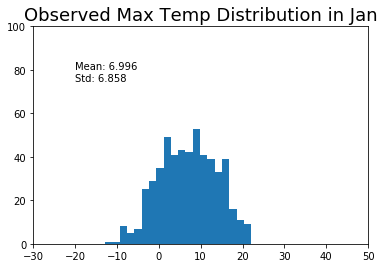

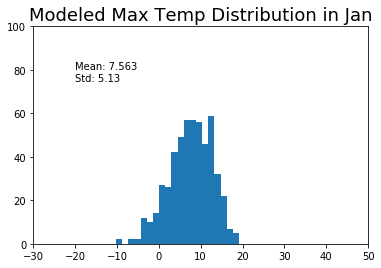

In [122]:
months = ['Jan','Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

def plotDists(final_preds):
    """Plotting the true and modeled distributions on a log scale"""
    for data, title in zip([Y_test.tmax, final_preds], ['Observed', 'Modeled']):
        length = data.shape[0] #number of pts
        pmean = round(float(data.mean()),3) #mean
        pstd = round(float(data.std()),3) #standard deviation

        #plot details
        plt.hist(data, bins = 20)
        plt.title(title + ' Max Temp Distribution in ' + months[month-1] ,fontsize=18) #title
        plt.xlim(xmin=-30, xmax = 50)
        plt.ylim(ymin=0, ymax = 100)

        #show mean and std
        plt.text(-20,75, "Mean: " + str(pmean) + "\nStd: " + str(pstd))
        plt.show()
        
plotDists(final_preds)

## Adding a normal distribution element

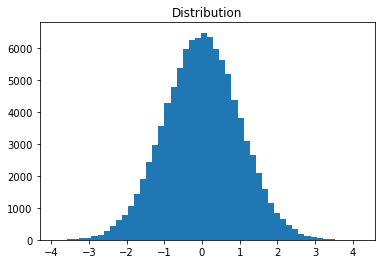

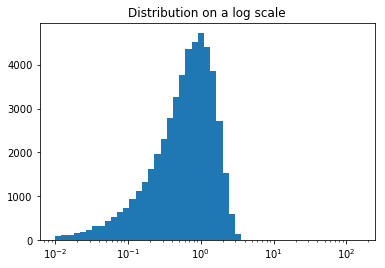

In [26]:
mu, sigma = 0, 1 #mean and standard deviation
data = np.random.normal(mu, sigma, 100000) #gettign 100,000 random points from this distribution

def makePlots(data):
    """Plotting a distibution on a normal scale and on a log scale."""
    
    #plotting a normal distribution
    plt.hist(data, bins = 50)
    plt.title('Distribution')
    plt.show()

    #plotting the same distribution on a log scale
    ax = plt.subplot()
    ax.set_xscale("log", nonposx='clip')
    logbins = np.geomspace(0.01,150, 50)
    plt.hist(data, bins=logbins)
    plt.title('Distribution on a log scale')
    plt.show()
    
makePlots(data)

## Gamma Distributions 

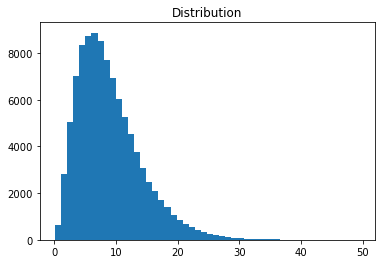

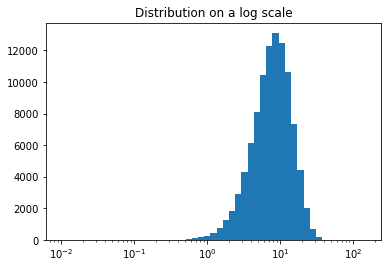

In [110]:
k = 3 #shape
theta = 3 #scale

makePlots(np.random.gamma(k,theta,100000))

## Adding a stochastic element to the predictions

You can change the distributions to see what works the best

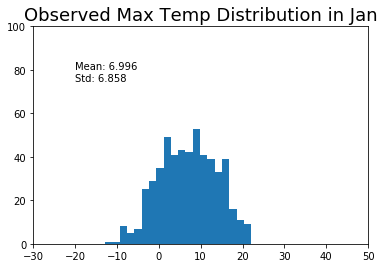

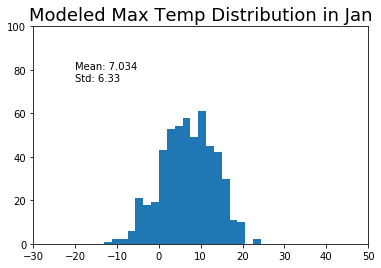

In [125]:
#Normal 
mu, sigma =-0.5, 4

#Gamma
k, theta = 2,5

np.random.seed(42)

#toggle these two lines to do a normal or gamma distribution
stochast = np.random.normal(mu, sigma, final_preds.shape[0])
#stochast = np.random.gamma(k,theta,final_preds.shape[0])

corrected_preds = final_preds + stochast

plotDists(corrected_preds)

### Write the final predictions to disk

In [126]:
#save location
location = '/glade/work/kwheelan/datasets'

#just saving as a txt file right now, but I could convert to xarray if needed
#saves just the predicted precip values in order of data
np.savetxt(os.path.join(location, 'oddYrPreds_TMAX_month' +str(month) + '_'+ str(lat) + '.' + str(lon) + '.txt'), corrected_preds, delimiter = ',')

## Climate Distributions

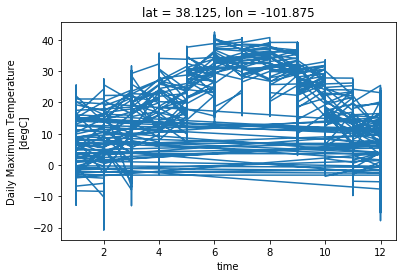

In [140]:
Y_all['tmax'].plot()

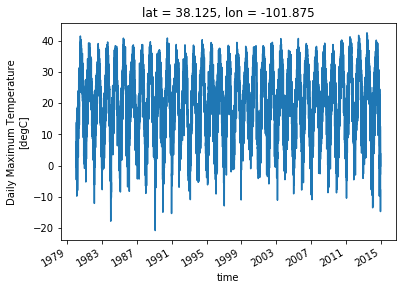

In [162]:
Y_edit = Y_all
Y_edit['time'] = Y_edit.timecopy
t = Y_edit.isel(time=slice(0, 365 * 2014-1980, 1))
t.tmax.plot()

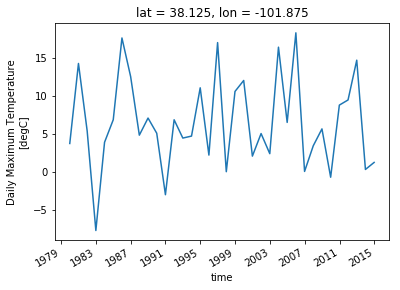

In [165]:
t = Y_edit.isel(time=slice(0, 365 * 2014-1980, 365))
t.tmax.plot()

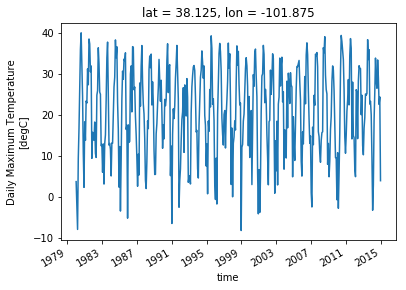

In [169]:
t = Y_edit.isel(time=slice(0, 365 * 2014-1980, 30))
t.tmax.plot()